In [52]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add the directory where dynamics.py and utils.py are located to sys.path
module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm import tqdm
from unkkt import UNKKT
from mm_newton import MM_Newton
from scipy.linalg import block_diag
from tree_newton import Tree_Newton
from dynamics import SatelliteDynamics
from approxh_newton import approxH_Newton
from utils import get_form_initial_conditions
from concurrent.futures import ProcessPoolExecutor

use_several_cpus = True

In [53]:
# Simulation parameters
dt = 60.0  # Time step [s]
T = 5  # Duration [min]
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6  # Number of states
n_p = 3  
n_y_1 = 3  # Number of measurements
n_y_2 = 2
n_y_3 = 2
n_y_4 = 2
K = T
W = T # Window size [min]
dynamic_model = SatelliteDynamics()

In [54]:
# Initial state vector and get the true state vectors (propagation) F
X_initial = get_form_initial_conditions(formation)
X_true = np.zeros((24, 1, T))
X_true[:, :, 0] = X_initial
for t in range(T - 1):
    X_true[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

# Process noise
q_chief_pos = 1e-1  # [m]
q_chief_vel = 1e-2 # [m / s]
Q_chief = (
    np.diag(np.concatenate([q_chief_pos * np.ones(3), q_chief_vel * np.ones(3)]))
    ** 2
)
q_deputy_pos = 1e0  # [m]
q_deputy_vel = 1e-2  # [m / s]
Q_deputy = (
    np.diag(np.concatenate([q_deputy_pos * np.ones(3), q_deputy_vel * np.ones(3)]))
    ** 2
)
Q_deputies = block_diag(Q_deputy, Q_deputy, Q_deputy)
Q = block_diag(Q_chief, Q_deputies)

# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])

In [55]:
tol = 1e-20
max_iter = 100

# Declare solvers
unkkt = UNKKT(W, R_chief, r_deputy_pos)
unkkt.grad_tol = tol
unkkt.max_iter = max_iter

tree_newton = Tree_Newton(W, R_chief, r_deputy_pos)
tree_newton.grad_tol = tol
tree_newton.max_iter = max_iter

approxh_newton = approxH_Newton(W, R_chief, r_deputy_pos)
approxh_newton.grad_tol = tol
approxh_newton.max_iter = max_iter

mm_newton = MM_Newton(W, R_chief, r_deputy_pos)
mm_newton.grad_tol = tol
mm_newton.max_iter = max_iter
mm_newton.mm_tol = tol
mm_newton.mm_max_iter = 1

In [56]:
# Fixed seed for reproducibility
np.random.seed(42)

X_est = np.zeros_like(X_true)
initial_dev = np.concatenate(
    (
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
    )
)
X_est[:, :, 0] = X_initial + initial_dev
for t in range(T - 1):
    X_est[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_est[:, :, t])

# Observations
Y = np.zeros((9, 1, T))
for t in range(T):
    Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((9, 1)), size=(9, 1))
    
dev_chief_initial = np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).reshape(-1, 1)
dev_deputy1_initial = np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).reshape(-1, 1)
dev_deputy2_initial = np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).reshape(-1, 1)
dev_deputy3_initial = np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).reshape(-1, 1)

Windows:   0%|          | 0/1 [00:00<?, ?it/s]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton --------


Before applying the algorithm
Cost function: 407861.7026876424
Gradient norm: 1039592.6452293027
Global relative error: 395.60563949432424
Position relative errors: 82.78540989608044 m, 181.7491507333766 m, 258.73787052498585 m, 222.8729633755392 m

Before applying the algorithm
Cost function: 378564.4951450868
Gradient norm: 1038803.6180803335
Global relative error: 395.60563949432424
Position relative errors: 82.78540989608044 m, 181.7491507333766 m, 258.73787052498585 m, 222.8729633755392 m

Before applying the algorithm
L_norm = 407861.7026876424
Grad_L_norm = 1039592.6452293027

Iteration 1
Cost function: 21427827.224874172 (5153.70%)
Gradient norm: 1896302.8324083046 (82.41%)
Global relative error: 771.5007166568923 (95.02%)
Position relative errors: 2.96840515291399 m, 103.03803043679373 m, 340.885781459331 m, 683.7227919521001 m

Iteration 1
Cost function: 132.45193872109948 (-99

/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=7.4551e-18): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 14
L_norm = 207.94717562421533
Grad_L_norm = 4612.201509524486

Iteration 16
Cost function: 801409.2033933925 (-91.17%)
Gradient norm: 197632.45641673513 (-87.35%)
Global relative error: 2017.725580657218 (-30.83%)
Position relative errors: 9.78185871871743 m, 1293.7297952776098 m, 1182.6794753229765 m, 998.9199915566702 m

Iteration 15
Cost function: 0.8835987355174796 (-0.43%)
Gradient norm: 0.6758453190585276 (-93.14%)
Global relative error: 874.1348201778476 (0.08%)
Position relative errors: 0.06566061727848051 m, 45.671459528966615 m, 332.58310545491213 m, 807.0949419427252 m

Iteration 15
L_norm = 1.5891541578224455
Grad_L_norm = 12.401232000430182

Iteration 17
Cost function: 385703.29486503836 (-51.87%)
Gradient norm: 195008.02723427775 (-1.33%)
Global relative error: 1788.7042792547506 (-11.35%)
Position relative errors: 4.164652492037368 m, 1147.3369177009495 m, 1090.2248636873678 m, 832.9371635239155 m

Iteration 16
Cost function: 0.8921606509833275 (0.97%)
Gradien

/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.73126e-18): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 16
L_norm = 1.5999221596595672
Grad_L_norm = 56.16052319607608

Iteration 18
Cost function: 163597.0219442798 (-57.58%)
Gradient norm: 100299.59009909489 (-48.57%)
Global relative error: 1688.128813934945 (-5.62%)
Position relative errors: 2.723841641686838 m, 1011.8776355933634 m, 1142.3608955096602 m, 721.2817227457398 m

Iteration 17
Cost function: 0.8829187859664911 (-1.04%)
Gradient norm: 0.01807346239988425 (-99.87%)
Global relative error: 893.4200982093042 (-0.00%)
Position relative errors: 0.06566061729632636 m, 45.73393171955755 m, 332.58340430711127 m, 827.939586872912 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.03934e-18): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 17
L_norm = 1.5752380606190024
Grad_L_norm = 0.028597485154054303

Iteration 19
Cost function: 766754.9265285843 (368.69%)
Gradient norm: 284619.2886560199 (183.77%)
Global relative error: 1946.0357461483006 (15.28%)
Position relative errors: 1.5134257841910406 m, 1160.5119861380683 m, 1083.2744990759372 m, 1125.238951336605 m

Iteration 18
Cost function: 844.057560048734 (95498.55%)
Gradient norm: 2833.16802606708 (15675745.41%)
Global relative error: 1278.7122066766763 (43.13%)
Position relative errors: 0.06566061726092261 m, 45.73393159048872 m, 332.5835431366013 m, 1233.848235140936 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=5.44739e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 18
L_norm = 753.304502725865
Grad_L_norm = 9122.847240487206

Iteration 20
Cost function: 298077.38411359594 (-61.12%)
Gradient norm: 162458.64683757353 (-42.92%)
Global relative error: 1755.2195968893855 (-9.81%)
Position relative errors: 2.0775531497432307 m, 966.4893895996544 m, 1137.1126756162128 m, 923.6337147643565 m

Iteration 19
Cost function: 0.9046300342404718 (-99.89%)
Gradient norm: 15.334392530666765 (-99.46%)
Global relative error: 1243.434498584923 (-2.76%)
Position relative errors: 0.06566061654649957 m, 45.73393163149166 m, 332.58359010173155 m, 1197.2499762067484 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=5.12458e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 19
L_norm = 1.6403261511695173
Grad_L_norm = 31.777580756630407

Iteration 21
Cost function: 1882904.665261841 (531.68%)
Gradient norm: 217816.4225537811 (34.07%)
Global relative error: 2888.647196406753 (64.57%)
Position relative errors: 9.317559194993322 m, 1488.1073255843626 m, 2036.0432089957806 m, 1408.2032587586868 m

Iteration 20
Cost function: 0.8781333373007291 (-2.93%)
Gradient norm: 0.0219619624251141 (-99.86%)
Global relative error: 1243.125730489166 (-0.02%)
Position relative errors: 0.06566061722979452 m, 45.73393162737011 m, 332.5835907413177 m, 1196.9292901498143 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=3.30076e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 20
L_norm = 1.5721758145247744
Grad_L_norm = 26.68278918747199

Iteration 22
Cost function: 351860.3781260154 (-81.31%)
Gradient norm: 100754.5412701774 (-53.74%)
Global relative error: 1997.5917203427543 (-30.85%)
Position relative errors: 5.730973783484086 m, 1096.7096398113217 m, 1218.1380602913418 m, 1141.4474388431902 m

Iteration 21
Cost function: 1.1295351200583619 (28.63%)
Gradient norm: 49.880163158889204 (227020.70%)
Global relative error: 1289.6992926335656 (3.75%)
Position relative errors: 0.06566061726807222 m, 45.73393160025124 m, 332.5835691542508 m, 1245.2314307663635 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=7.228e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 21
L_norm = 1.5667279819507942
Grad_L_norm = 0.9916626450555047

Iteration 23
Cost function: 83942954.28069898 (23756.89%)
Gradient norm: 3739010.5275746128 (3611.01%)
Global relative error: 2232.429345844059 (11.76%)
Position relative errors: 9.066694669909316 m, 978.5565113491413 m, 1828.4627949351611 m, 823.5388517680428 m

Iteration 22
Cost function: 0.8776030227846107 (-22.30%)
Gradient norm: 0.013577171890256876 (-99.97%)
Global relative error: 1289.0786975070641 (-0.05%)
Position relative errors: 0.06566061727780237 m, 45.733931644399284 m, 332.5835681262339 m, 1244.5886741079976 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=3.10524e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 22
L_norm = 1.5681555368755027
Grad_L_norm = 15.236812913714227

Iteration 24
Cost function: 35003410.36519547 (-58.30%)
Gradient norm: 2243017.3326451844 (-40.01%)
Global relative error: 4068.2831641085572 (82.24%)
Position relative errors: 18.46107366261081 m, 3256.1597627514384 m, 1056.5496305389406 m, 2197.253932564571 m

Iteration 23
Cost function: 396.2397365221453 (45050.22%)
Gradient norm: 1855.2161030583677 (13664130.80%)
Global relative error: 1585.4291351466127 (22.99%)
Position relative errors: 0.0656606172287091 m, 45.733931597936 m, 332.5838705157857 m, 1549.469180532246 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=3.38433e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 23
L_norm = 1.5656588697897889
Grad_L_norm = 0.019394676555112428

Iteration 25
Cost function: 7575577.4292394165 (-78.36%)
Gradient norm: 950156.4909994517 (-57.64%)
Global relative error: 3437.8652466157896 (-15.50%)
Position relative errors: 21.22712621974299 m, 1807.9462346433725 m, 2325.3311294736336 m, 1772.1871532016933 m

Iteration 24
Cost function: 0.8855523066193436 (-99.78%)
Gradient norm: 9.233595879866954 (-99.50%)
Global relative error: 1554.7913994379383 (-1.93%)
Position relative errors: 0.06566061748971228 m, 45.7339316118774 m, 332.58391637537477 m, 1518.1064070148195 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=8.2289e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 24
L_norm = 197.79667062915954
Grad_L_norm = 4662.173011809495

Iteration 26
Cost function: 17328060.690321986 (128.74%)
Gradient norm: 1583454.125705742 (66.65%)
Global relative error: 3034.0535054551224 (-11.75%)
Position relative errors: 17.442859803488236 m, 1944.1434880908707 m, 1837.0474787415196 m, 1431.3538255400576 m

Iteration 25
Cost function: 0.8759702545321886 (-1.08%)
Gradient norm: 1.8850496814970426 (-79.58%)
Global relative error: 1553.86625405929 (-0.06%)
Position relative errors: 0.06566061717022072 m, 45.733931623701835 m, 332.583918031292 m, 1517.1587928712925 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=3.22782e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 25
L_norm = 1.56792473911263
Grad_L_norm = 8.56940146881033

Iteration 27
Cost function: 2369131.970718603 (-86.33%)
Gradient norm: 425989.80302185536 (-73.10%)
Global relative error: 2773.3377362209467 (-8.59%)
Position relative errors: 10.409473123365034 m, 1613.0837570444774 m, 1733.133651981186 m, 1443.7830938427674 m

Iteration 26
Cost function: 0.8753597317143381 (-0.07%)
Gradient norm: 1.9912228698527101 (5.63%)
Global relative error: 1560.8603432942973 (0.45%)
Position relative errors: 0.0656606172283111 m, 45.73393161058612 m, 332.58392025514104 m, 1524.3210791426447 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.61413e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 26
L_norm = 1.5615388678761721
Grad_L_norm = 1.3450750177150212

Iteration 28
Cost function: 5113931.552075528 (115.86%)
Gradient norm: 396739.4048509257 (-6.87%)
Global relative error: 3872.161111395625 (39.62%)
Position relative errors: 9.835719062168703 m, 1865.7083639077487 m, 2713.575983413232 m, 2036.6951277971782 m
Iteration 27
Cost function: 0.8750134675237435 (-0.04%)
Gradient norm: 0.07128897817846913 (-96.42%)
Global relative error: 1561.3587456179698 (0.03%)

Position relative errors: 0.06566061727366158 m, 45.73393159766088 m, 332.5839236136199 m, 1524.8313956375216 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=5.21322e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 27
L_norm = 1.5615334565710686
Grad_L_norm = 3.0861069261096645

Iteration 28
Cost function: 1.856887128785883 (112.21%)
Gradient norm: 86.94124719816317 (121856.09%)
Global relative error: 1620.365623558472 (3.78%)
Position relative errors: 0.0656606172395639 m, 45.733931632828444 m, 332.58390176824565 m, 1585.1979146059132 m
Iteration 29
Cost function: 2084854.3343265697 (-59.23%)
Gradient norm: 587710.8008794412 (48.14%)
Global relative error: 3068.7989675475465 (-20.75%)



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.54425e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Position relative errors: 11.638112057993597 m, 1594.7470427580458 m, 1614.591877824731 m, 2065.527786510865 m

Iteration 29
Cost function: 0.8745434471847714 (-52.90%)
Gradient norm: 0.08950724041736242 (-99.90%)
Global relative error: 1618.6295114665345 (-0.11%)
Position relative errors: 0.0656606172492848 m, 45.733931604159025 m, 332.5838993995728 m, 1583.42327702764 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=8.02874e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 30
Cost function: 544805.213728237 (-73.87%)
Gradient norm: 179096.86354033824 (-69.53%)
Global relative error: 2892.665866496233 (-5.74%)
Position relative errors: 6.39628222843665 m, 1740.9251283008607 m, 1685.0649455635694 m, 1580.1273134520275 m

Iteration 28
L_norm = 1.5614227012253603
Grad_L_norm = 0.15567123197011398

Iteration 30
Cost function: 1.3241877779319557 (51.41%)
Gradient norm: 58.58049725964778 (65347.77%)
Global relative error: 1661.4621288176256 (2.65%)
Position relative errors: 0.0656606172278031 m, 45.733931600146256 m, 332.58388893265123 m, 1627.1824695997168 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.76873e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 31
Cost function: 6438339725.656726 (1181669.11%)
Gradient norm: 31634310.63752115 (17563.24%)
Global relative error: 27755.225219646807 (859.50%)
Position relative errors: 118.50893434196536 m, 27609.22356782063 m, 2461.4135361853137 m, 1350.4905396573072 m

Iteration 29
L_norm = 1.5904798535654325
Grad_L_norm = 57.00249536522037

Iteration 31
Cost function: 0.8742381117195637 (-33.98%)
Gradient norm: 0.01153311370065572 (-99.98%)
Global relative error: 1660.3894357072627 (-0.06%)
Position relative errors: 0.06566061725380654 m, 45.73393159903204 m, 332.5838861248183 m, 1626.0871800335608 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=4.22574e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 32
Cost function: 2200095934.732339 (-65.83%)
Gradient norm: 17947544.914747152 (-43.27%)
Global relative error: 18438.042254860597 (-33.57%)
Position relative errors: 99.087446261705 m, 1661.5216698893692 m, 11223.168301856871 m, 14530.381629568938 m

Iteration 30
L_norm = 1.5610932036628664
Grad_L_norm = 0.0025924777892809637

Iteration 32
Cost function: 21.998870955473233 (2416.35%)
Gradient norm: 408.145407919198 (3538800.41%)
Global relative error: 1784.880726669849 (7.50%)
Position relative errors: 0.06566061720808931 m, 45.73393161548762 m, 332.5825362590334 m, 1753.0148962562355 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=9.1425e-18): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 33
Cost function: 529314348.9732603 (-75.94%)
Gradient norm: 6575864.168931517 (-63.36%)
Global relative error: 13356.902705991963 (-27.56%)
Position relative errors: 109.07820898937068 m, 11211.707986890558 m, 5510.397969732882 m, 4720.998012165066 m

Iteration 31
L_norm = 484.6372022881302
Grad_L_norm = 7319.429368171439

Iteration 33
Cost function: 0.8748946526756919 (-96.02%)
Gradient norm: 2.9299087153961816 (-99.28%)
Global relative error: 1775.384865083295 (-0.53%)
Position relative errors: 0.06566061702156764 m, 45.73393161255193 m, 332.58253586315067 m, 1743.3456692781808 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=3.26312e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 34
Cost function: 164200527.7653196 (-68.98%)
Gradient norm: 2673221.830810939 (-59.35%)
Global relative error: 9329.320466667208 (-30.15%)
Position relative errors: 114.13756007229205 m, 4094.7821483925627 m, 5753.206515060433 m, 6094.240091069771 m

Iteration 32
L_norm = 1.5930184577595523
Grad_L_norm = 20.699789809503446

Iteration 34
Cost function: 0.873461438274439 (-0.16%)
Gradient norm: 1.662987625546668 (-43.24%)
Global relative error: 1774.409375969833 (-0.05%)
Position relative errors: 0.06566061714553305 m, 45.73393160963152 m, 332.58251325460753 m, 1742.3521576341823 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.56057e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 35
Cost function: 2791201665.005149 (1599.87%)
Gradient norm: 19540904.11273644 (630.99%)
Global relative error: 12739.376694105265 (36.55%)
Position relative errors: 138.65767098880121 m, 4370.3557009305505 m, 7594.521546151697 m, 9238.989754695109 m

Iteration 33
L_norm = 1.5595969256739302
Grad_L_norm = 6.964109452974742

Iteration 35
Cost function: 0.8733570425716991 (-0.01%)
Gradient norm: 0.18897550558756682 (-88.64%)
Global relative error: 1776.3421657734364 (0.11%)
Position relative errors: 0.06566061725630377 m, 45.73393163985646 m, 332.5825117930452 m, 1744.3203956698485 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=3.27007e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 36
Cost function: 491501201.437338 (-82.39%)
Gradient norm: 6582334.775749968 (-66.32%)
Global relative error: 8610.020863357466 (-32.41%)
Position relative errors: 98.2333170002149 m, 6222.522651921757 m, 4328.8181863107375 m, 4076.9282822813025 m

Iteration 34
L_norm = 1.5591223803417236
Grad_L_norm = 0.5038577483840294

Iteration 36
Cost function: 0.8733400325778113 (-0.00%)
Gradient norm: 0.6864494156049659 (263.25%)
Global relative error: 1778.8559840521434 (0.14%)
Position relative errors: 0.06566061721674014 m, 45.73393159846699 m, 332.58251508702256 m, 1746.880239957792 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=2.64045e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 37
Cost function: 144292838.1327681 (-70.64%)
Gradient norm: 2562918.059443887 (-61.06%)
Global relative error: 6225.898574575831 (-27.69%)
Position relative errors: 71.04688038933453 m, 3247.3923832764067 m, 3700.6362050306184 m, 3807.6322408858987 m

Iteration 35
L_norm = 1.5590930932776765
Grad_L_norm = 0.38244155192021423

Iteration 37
Cost function: 0.8733188317228624 (-0.00%)
Gradient norm: 0.1526355118627522 (-77.76%)
Global relative error: 1780.7338039739268 (0.11%)
Position relative errors: 0.06566061724088536 m, 45.733931608393696 m, 332.58251576227644 m, 1748.7923647647995 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.68321e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 38
Cost function: 258088963.92833322 (78.86%)
Gradient norm: 1555260.7128701687 (-39.32%)
Global relative error: 27562.750193814132 (342.71%)
Position relative errors: 350.495532454182 m, 2853.937736436483 m, 21700.28885479549 m, 16748.454701943985 m

Iteration 36
L_norm = 1.5590897545010975
Grad_L_norm = 0.13551214713482046

Iteration 38
Cost function: 0.8733254714798017 (0.00%)
Gradient norm: 1.318357323912224 (763.73%)
Global relative error: 1784.4611783268417 (0.21%)
Position relative errors: 0.06566061720428122 m, 45.73393162243212 m, 332.58251585998715 m, 1752.5876048784025 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.00794e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 39
Cost function: 61124116.21484206 (-76.32%)
Gradient norm: 813106.4938692896 (-47.72%)
Global relative error: 17027.22576190269 (-38.22%)
Position relative errors: 236.61865485721125 m, 12968.553506859169 m, 7139.332894663432 m, 8408.851189386094 m

Iteration 37
L_norm = 1.5590922397792417
Grad_L_norm = 0.89807118440491

Iteration 39
Cost function: 0.8732811371459448 (-0.01%)
Gradient norm: 0.03589211016610662 (-97.28%)
Global relative error: 1785.2970331582367 (0.05%)
Position relative errors: 0.06566061723467832 m, 45.733931646398744 m, 332.58251737878163 m, 1753.4386397947321 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=7.13779e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 38
L_norm = 1.5590842658526203
Grad_L_norm = 0.020390721550007002
Iteration 40
Cost function: 855211105.3850567 (1299.14%)
Gradient norm: 11202754.623960173 (1277.77%)
Global relative error: 11276.173257680715 (-33.78%)

Position relative errors: 132.25606136456537 m, 5901.643894654432 m, 8256.893639731652 m, 4908.133366492373 m

Iteration 40
Cost function: 0.8872746639441843 (1.60%)
Gradient norm: 22.751240145120367 (63287.86%)
Global relative error: 1802.3433852445014 (0.95%)
Position relative errors: 0.06566061719883451 m, 45.73393160328691 m, 332.5826033799058 m, 1770.791375782648 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=7.10789e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 39
L_norm = 1.5613677657424587
Grad_L_norm = 15.936874724124497
Iteration 41
Cost function: 107365663.70067985 (-87.45%)
Gradient norm: 3261962.3999674604 (-70.88%)
Global relative error: 7281.387909809724 (-35.43%)

Position relative errors: 76.1579288312262 m, 4047.843760853541 m, 3207.277525544713 m, 5131.554672691255 m

Iteration 41
Cost function: 0.8731525345710605 (-1.59%)
Gradient norm: 0.00353284330700592 (-99.98%)
Global relative error: 1802.093231251057 (-0.01%)
Position relative errors: 0.06566061722665549 m, 45.73393164167843 m, 332.5826058273673 m, 1770.5367679499136 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.2943e-18): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 40
L_norm = 1.5590690778887988
Grad_L_norm = 0.00019565581108800027
Iteration 42
Cost function: 23682737.303779293 (-77.94%)
Gradient norm: 1070505.6172010526 (-67.18%)
Global relative error: 5284.252195331984 (-27.43%)

Position relative errors: 55.37067568095978 m, 3077.1500103886106 m, 3217.6553660629065 m, 2845.22600738436 m

Iteration 42
Cost function: 121.18831035883777 (13779.40%)
Gradient norm: 806.208907618401 (22820298.12%)
Global relative error: 1963.1702234601507 (8.94%)
Position relative errors: 0.06566061718188577 m, 45.73393160365643 m, 332.5825793973552 m, 1934.2414391338366 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=5.1914e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 41
L_norm = 1.579325174571658
Grad_L_norm = 47.32198039150644

Iteration 43
Cost function: 21272253.154522695 (-10.18%)
Gradient norm: 606051.3654563195 (-43.39%)
Global relative error: 7854.60208071229 (48.64%)
Position relative errors: 59.956681754878275 m, 3610.081697873864 m, 6482.97298277707 m, 2574.044256940636 m

Iteration 43
Cost function: 0.880186964062181 (-99.27%)
Gradient norm: 8.037678683419674 (-99.00%)
Global relative error: 1940.4648209652441 (-1.16%)
Position relative errors: 0.06566061695104033 m, 45.733931620530065 m, 332.5826319158641 m, 1911.1928407956507 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=6.36545e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 42
L_norm = 1.5590588034295751
Grad_L_norm = 0.0009645704855225891

Iteration 44
Cost function: 3700563.195671375 (-82.60%)
Gradient norm: 320950.06172042066 (-47.04%)
Global relative error: 5241.860427988776 (-33.26%)
Position relative errors: 35.46437529849391 m, 2999.1394726719623 m, 2683.0522623640263 m, 3358.6528131345267 m

Iteration 44
Cost function: 0.8742359011399049 (-0.68%)
Gradient norm: 5.92043261186567 (-26.34%)
Global relative error: 1938.405710320739 (-0.11%)
Position relative errors: 0.06566061697400714 m, 45.733931624891426 m, 332.582635460259 m, 1909.1019927034956 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=6.8004e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 43
L_norm = 1.559058792905232
Grad_L_norm = 0.007895743175609834

Iteration 45
Cost function: 0.8727673242228375 (-0.17%)
Gradient norm: 2.054649158549079 (-65.30%)
Global relative error: 1938.5671205012823 (0.01%)
Position relative errors: 0.06566061711382282 m, 45.7339316162542 m, 332.5826322410263 m, 1909.2657374505193 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.53146e-18): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 45
Cost function: 5410311.653787277 (46.20%)
Gradient norm: 903850.8707785172 (181.62%)
Global relative error: 4392.155305592536 (-16.21%)
Position relative errors: 23.330568216789434 m, 2551.5532851105822 m, 2843.5891459664226 m, 2166.343233183466 m

Iteration 44
L_norm = 1.5590587923158314
Grad_L_norm = 1.1718550731920778e-05

Iteration 46
Cost function: 0.8724174393813289 (-0.04%)
Gradient norm: 1.0113349363324353 (-50.78%)
Global relative error: 1938.7571802493821 (0.01%)
Position relative errors: 0.06566061719470631 m, 45.73393159359107 m, 332.5826351490422 m, 1909.4586098658174 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.17362e-18): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 46
Cost function: 768783.2638398658 (-85.79%)
Gradient norm: 246097.9157032696 (-72.77%)
Global relative error: 3876.644642365588 (-11.74%)
Position relative errors: 14.42048014215578 m, 2191.2688396065473 m, 2320.150382007445 m, 2200.6498824188416 m

Iteration 45
L_norm = 1.5590587916988146
Grad_L_norm = 5.224634024591574e-06

Iteration 47
Cost function: 0.8723770893064231 (-0.00%)
Gradient norm: 0.1017922494636592 (-89.93%)
Global relative error: 1939.4948459693933 (0.04%)
Position relative errors: 0.06566061717548341 m, 45.73393163858606 m, 332.58263267260423 m, 1910.2075439627424 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=9.28155e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 47
Cost function: 17283684.47714345 (2148.19%)
Gradient norm: 318036.4938095564 (29.23%)
Global relative error: 8199.172396794109 (111.50%)
Position relative errors: 77.21887232009425 m, 5515.805393740335 m, 1871.8933317607225 m, 5769.790222269307 m

Iteration 46
L_norm = 1.559058791935699
Grad_L_norm = 4.062001676390971e-06

Iteration 48
Cost function: 0.872414899550764 (0.00%)
Gradient norm: 1.7543834252910662 (1623.49%)
Global relative error: 1942.7516365800016 (0.17%)
Position relative errors: 0.06566061719006376 m, 45.733931606570714 m, 332.582634756906 m, 1913.5140844778143 m
Iteration 48
Cost function: 3722341.972676671 (-78.46%)
Gradient norm: 147586.65210714613 (-53.59%)
Global relative error: 5228.054660955925 (-36.24%)

Position relative errors: 53.440974141889484 m, 2611.5378751542166 m, 4002.5650999731743 m, 2118.564207158999 m


/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.01381e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)



Iteration 47
L_norm = 1.559058792418218
Grad_L_norm = 4.124733967365106e-06

Iteration 49
Cost function: 1925059.6602926 (-48.28%)
Gradient norm: 349221.61093275197 (136.62%)
Global relative error: 3952.5962045510823 (-24.40%)
Position relative errors: 37.872720052614014 m, 2185.349647683768 m, 2528.0720033949583 m, 2110.4050595859935 m

Iteration 49
Cost function: 0.8723520601104292 (-0.01%)
Gradient norm: 0.009590469061428183 (-99.45%)
Global relative error: 1943.0970675962938 (0.02%)
Position relative errors: 0.06566061717444167 m, 45.73393159627388 m, 332.58263392630687 m, 1913.8647840769067 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=3.08258e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 48
L_norm = 1.559058792395097
Grad_L_norm = 6.1037802764702e-06

Iteration 50
Cost function: 480014.6252579669 (-75.06%)
Gradient norm: 171869.33780758502 (-50.79%)
Global relative error: 3021.9437840096366 (-23.55%)
Position relative errors: 16.21707898706074 m, 1788.385598019119 m, 1864.9020718838851 m, 1566.8773408678728 m

Iteration 50
Cost function: 1.1314339911373683 (29.70%)
Gradient norm: 117.71283384554685 (1227293.92%)
Global relative error: 1969.4556784190768 (1.36%)
Position relative errors: 0.06566061717899453 m, 45.73393158939684 m, 332.5826227109342 m, 1940.6196941333053 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=4.41928e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 49
L_norm = 1.5590587911913987
Grad_L_norm = 1.222168277670159e-05

Iteration 51
Cost function: 913886763.2202603 (190287.27%)
Gradient norm: 12354930.114311889 (7088.56%)
Global relative error: 6794.957897076323 (124.85%)
Position relative errors: 16.756960915388934 m, 1519.6049046885942 m, 6474.799696192548 m, 1376.2111815762617 m

Iteration 50
L_norm = 1.559058792433856
Grad_L_norm = 6.101697725412593e-06

Iteration 51
Cost function: 0.8721971666833005 (-22.91%)
Gradient norm: 0.056897088716655636 (-99.95%)
Global relative error: 1967.995871530252 (-0.07%)
Position relative errors: 0.06566061715567714 m, 45.733931599800144 m, 332.58262213428407 m, 1939.1382079402485 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.17585e-18): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 52
Cost function: 207851887.44816038 (-77.26%)
Gradient norm: 5234473.666665306 (-57.63%)
Global relative error: 4525.709625696916 (-33.40%)
Position relative errors: 39.3263888652257 m, 2796.261829034433 m, 1239.5927002806352 m, 3332.401565917062 m

Iteration 51
L_norm = 1.5590587923648704
Grad_L_norm = 4.176608957559347e-06

Iteration 52
Cost function: 0.8721934284955118 (-0.00%)
Gradient norm: 0.7846126181069942 (1279.00%)
Global relative error: 1969.916597898971 (0.10%)
Position relative errors: 0.06566061720763146 m, 45.73393161460622 m, 332.5826226439778 m, 1941.087432172632 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=9.40755e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 53
Cost function: 79205915598.92915 (38006.90%)
Gradient norm: 144797112.9763147 (2666.22%)
Global relative error: 35092.576967680645 (675.40%)
Position relative errors: 578.9401335736959 m, 1383.64142580135 m, 35013.19985384728 m, 1175.5002251413307 m

Iteration 52
L_norm = 1.5590587922993562
Grad_L_norm = 4.179762764432423e-06

Iteration 53
Cost function: 0.8721792438556595 (-0.00%)
Gradient norm: 0.03524151046170607 (-95.51%)
Global relative error: 1970.6398821040657 (0.04%)
Position relative errors: 0.06566061717287443 m, 45.73393162904343 m, 332.58262188410947 m, 1941.8214344220116 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=5.02022e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 54
Cost function: 12412342579.247362 (-84.33%)
Gradient norm: 37672311.21075736 (-73.98%)
Global relative error: 71971.0701352436 (105.09%)
Position relative errors: 684.2230554505499 m, 52033.08544858174 m, 1193.122837021252 m, 49692.46922078312 m

Iteration 53
L_norm = 1.5590587916145702
Grad_L_norm = 4.356881232747874e-06

Iteration 54
Cost function: 0.8730124208222547 (0.10%)
Gradient norm: 7.701727343699537 (21754.14%)
Global relative error: 1975.7461264558415 (0.26%)
Position relative errors: 0.06566061717490733 m, 45.73393162175523 m, 332.58262310929223 m, 1947.003077903037 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.12682e-18): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 55
Cost function: 4111694857.4200225 (-66.87%)
Gradient norm: 18483869.17159125 (-50.94%)
Global relative error: 52990.202909294974 (-26.37%)
Position relative errors: 288.10875246323036 m, 13948.328626706092 m, 49030.858810573605 m, 14448.181516987084 m

Iteration 54
L_norm = 1.5590587923957477
Grad_L_norm = 4.112698614030436e-06

Iteration 55
Cost function: 0.8721482219035368 (-0.10%)
Gradient norm: 0.0008361685687041077 (-99.99%)
Global relative error: 1975.7708932422713 (0.00%)
Position relative errors: 0.06566061715705906 m, 45.733931621044725 m, 332.5826204071747 m, 1947.028209901386 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=5.4786e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 56
Cost function: 1498039880.7298217 (-63.57%)
Gradient norm: 9880328.172620025 (-46.55%)
Global relative error: 33654.29609591999 (-36.49%)
Position relative errors: 475.45926817905973 m, 22664.914772705328 m, 10327.96255358259 m, 22622.848046300776 m

Iteration 55
L_norm = 1.559058792434971
Grad_L_norm = 4.178284639281649e-06

Iteration 56
Cost function: 43.71811037169457 (4912.69%)
Gradient norm: 574.6648065057708 (68725851.68%)
Global relative error: 2078.1106114054405 (5.18%)
Position relative errors: 0.06566061717867211 m, 45.73393159747476 m, 332.5825720306125 m, 2050.799942541826 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=3.13354e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 57
Cost function: 560592469.9474998 (-62.58%)
Gradient norm: 5108063.723908238 (-48.30%)
Global relative error: 18670.266050695485 (-44.52%)
Position relative errors: 235.1023657609921 m, 7076.785962399059 m, 15777.02715117342 m, 7030.914346696563 m

Iteration 56
L_norm = 1.5590587925929165
Grad_L_norm = 6.21191476742605e-06

Iteration 57
Cost function: 0.9041011757898387 (-97.93%)
Gradient norm: 17.494634060016605 (-96.96%)
Global relative error: 2058.991378160861 (-0.92%)
Position relative errors: 0.0656606175407172 m, 45.733931644748026 m, 332.58255603803246 m, 2031.4242555451176 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=3.24932e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 58
Cost function: 245913856.76936665 (-56.13%)
Gradient norm: 3494706.0587713066 (-31.58%)
Global relative error: 13395.943798985423 (-28.25%)
Position relative errors: 184.7957443477854 m, 8711.665221744464 m, 5352.870906494756 m, 8650.37411578047 m

Iteration 57
L_norm = 1.55905879103258
Grad_L_norm = 1.2310055989805491e-05

Iteration 58
Cost function: 0.8735148798349002 (-3.38%)
Gradient norm: 1.81420725320294 (-89.63%)
Global relative error: 2056.255268269039 (-0.13%)
Position relative errors: 0.06566061663598692 m, 45.733931587918 m, 332.5825558891759 m, 2028.6509026581807 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=5.4097e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 59
Cost function: 124386294.74021089 (-49.42%)
Gradient norm: 2418139.2616030835 (-30.81%)
Global relative error: 10929.273914495729 (-18.41%)
Position relative errors: 105.3268727684643 m, 6434.5835649170795 m, 6073.357202401756 m, 6413.286934702514 m

Iteration 58
L_norm = 1.5590587924396735
Grad_L_norm = 6.212271068133993e-06

Iteration 59
Cost function: 0.8723874543321342 (-0.13%)
Gradient norm: 6.013248667252799 (231.45%)
Global relative error: 2054.092885506464 (-0.11%)
Position relative errors: 0.06566061705188589 m, 45.733931619364775 m, 332.58255649217523 m, 2026.4588467208932 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=4.0689e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 60
Cost function: 39552602.959838346 (-68.20%)
Gradient norm: 1288502.6645903825 (-46.72%)
Global relative error: 5521.343108379475 (-49.48%)
Position relative errors: 39.59971020507875 m, 2197.827160390131 m, 4532.255917769692 m, 2259.393750149425 m

Iteration 59
L_norm = 1.559058792154797
Grad_L_norm = 4.192040257250151e-06

Iteration 60
Cost function: 0.8718275187504643 (-0.06%)
Gradient norm: 0.16000924912498493 (-97.34%)
Global relative error: 2053.739656679444 (-0.02%)
Position relative errors: 0.06566061707414056 m, 45.73393163540201 m, 332.5825562245173 m, 2026.1007635520596 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.03511e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 61
Cost function: 16016613.832054302 (-59.51%)
Gradient norm: 652619.9121328073 (-49.35%)
Global relative error: 7183.621762059801 (30.11%)
Position relative errors: 43.521569300203296 m, 4899.84968911654 m, 1730.1556947832978 m, 4959.511068243695 m

Iteration 60
L_norm = 1.5590587923995978
Grad_L_norm = 4.190427603787627e-06

Iteration 61
Cost function: 0.8718055053037507 (-0.00%)
Gradient norm: 0.3258707253709317 (103.66%)
Global relative error: 2054.540164670342 (0.04%)
Position relative errors: 0.06566061710884075 m, 45.733931613399264 m, 332.58255398688885 m, 2026.9120984179033 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=2.71419e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 62
Cost function: 4388007.740439451 (-72.60%)
Gradient norm: 355093.10238686047 (-45.59%)
Global relative error: 4919.931068530528 (-31.51%)
Position relative errors: 14.740231220723789 m, 1869.8708818365053 m, 4010.675922743305 m, 2149.855878408743 m

Iteration 61
L_norm = 1.559058791516692
Grad_L_norm = 4.404173190642321e-06

Iteration 62
Cost function: 0.8717946020592248 (-0.00%)
Gradient norm: 0.018247603393586876 (-94.40%)
Global relative error: 2054.704695192471 (0.01%)
Position relative errors: 0.06566061710374826 m, 45.733931605369605 m, 332.5825531365858 m, 2027.078860302602 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=8.90065e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 63
Cost function: 1639151.896775579 (-62.64%)
Gradient norm: 204004.09886421062 (-42.55%)
Global relative error: 4985.578878118071 (1.33%)
Position relative errors: 14.588044149835248 m, 3296.939974134612 m, 2200.0279584099367 m, 3024.0025611548695 m

Iteration 62
L_norm = 1.559058792387968
Grad_L_norm = 4.2423581805982735e-06

Iteration 64
Cost function: 4837454.982134139 (195.12%)
Gradient norm: 846619.3989308017 (315.00%)
Global relative error: 4484.420689445078 (-10.05%)
Position relative errors: 8.635626582096814 m, 2497.0491845260763 m, 2674.074915283205 m, 2592.878640937329 m

Iteration 63
Cost function: 0.8973879367759215 (2.94%)
Gradient norm: 9.436634081771745 (51614.38%)
Global relative error: 2063.989542602284 (0.45%)
Position relative errors: 0.06566061709632068 m, 45.73393162386554 m, 332.58255282556365 m, 2036.489268590114 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=3.79275e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 63
L_norm = 1.5590587922417738
Grad_L_norm = 4.054037120496129e-06

Iteration 65
Cost function: 1000510.9987578396 (-79.32%)
Gradient norm: 276503.3565175799 (-67.34%)
Global relative error: 4249.167650584733 (-5.25%)
Position relative errors: 7.467453204956803 m, 2458.183875411839 m, 2460.9826044465426 m, 2440.409277432864 m

Iteration 64
L_norm = 1.5590587923535257
Grad_L_norm = 6.112908605283455e-06

Iteration 64
Cost function: 0.8717648854420552 (-2.86%)
Gradient norm: 0.01095527248097448 (-99.88%)
Global relative error: 2063.5053277234956 (-0.02%)
Position relative errors: 0.0656606170842268 m, 45.73393160675456 m, 332.58255505173275 m, 2035.9985252487072 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=2.05999e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 66
Cost function: 1031463.038573676 (3.09%)
Gradient norm: 172104.58389524234 (-37.76%)
Global relative error: 4031.7799634064468 (-5.12%)
Position relative errors: 7.895913972157861 m, 2341.447350735185 m, 2689.650075002898 m, 1880.9107396270615 m

Iteration 65
L_norm = 1.5590587912654967
Grad_L_norm = 1.22875446275577e-05

Iteration 65
Cost function: 0.9351973565431742 (7.28%)
Gradient norm: 14.773229367538335 (134750.41%)
Global relative error: 2072.169030381904 (0.42%)
Position relative errors: 0.06566061710880323 m, 45.7339316056782 m, 332.5825651644939 m, 2044.7784534756458 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=8.05432e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 67
Cost function: 400503.1038740817 (-61.17%)
Gradient norm: 114005.8657928213 (-33.76%)
Global relative error: 3921.0454788372404 (-2.75%)
Position relative errors: 4.8715836933258405 m, 2310.7945398817837 m, 2231.7948033554867 m, 2247.9686550946553 m

Iteration 66
L_norm = 1.5590587923494519
Grad_L_norm = 6.191195493507696e-06

Iteration 66
Cost function: 0.8717387284762598 (-6.79%)
Gradient norm: 0.00578333556225734 (-99.96%)
Global relative error: 2071.5704451652755 (-0.03%)
Position relative errors: 0.0656606170846892 m, 45.733931607820224 m, 332.58256375376067 m, 2044.1718597684676 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=2.40729e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 68
Cost function: 6763539.014045981 (1588.76%)
Gradient norm: 1040946.2172280175 (813.06%)
Global relative error: 3868.474082088233 (-1.34%)
Position relative errors: 1.4437841341162778 m, 2300.4966301532954 m, 2183.966855672696 m, 2214.0998407735133 m

Iteration 67
L_norm = 1.5590587923102963
Grad_L_norm = 4.161011303868129e-06

Iteration 67
Cost function: 0.9411098193284728 (7.96%)
Gradient norm: 12.510052349646797 (216212.06%)
Global relative error: 2079.9682846745804 (0.41%)
Position relative errors: 0.06566061708624917 m, 45.73393159173264 m, 332.5825448324985 m, 2052.6814165814217 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.79327e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 69
Cost function: 310096.0443032597 (-95.42%)
Gradient norm: 127298.30628830899 (-87.77%)
Global relative error: 3703.919453745265 (-4.25%)
Position relative errors: 3.490423031287704 m, 2130.0158787176733 m, 2039.6332402818655 m, 2240.8596004341985 m

Iteration 68
L_norm = 1.5590587921763601
Grad_L_norm = 4.147405517287515e-06

Iteration 68
Cost function: 0.8717149026726048 (-7.37%)
Gradient norm: 0.01286917506055076 (-99.90%)
Global relative error: 2079.2997611649976 (-0.03%)
Position relative errors: 0.06566061709120445 m, 45.7339316269445 m, 332.58254445951667 m, 2052.0040190973473 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.31715e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 70
Cost function: 337927.6679065217 (8.98%)
Gradient norm: 164275.82067328843 (29.05%)
Global relative error: 3516.652640097473 (-5.06%)
Position relative errors: 4.788360691613835 m, 2015.849614549663 m, 1985.7210957308887 m, 2087.9525621461567 m

Iteration 69
L_norm = 1.5590587914491347
Grad_L_norm = 4.236846764606843e-06

Iteration 69
Cost function: 0.8854724515481184 (1.58%)
Gradient norm: 5.554052725002105 (43057.80%)
Global relative error: 2083.921891934638 (0.22%)
Position relative errors: 0.06566061708732569 m, 45.73393160313625 m, 332.58254686755515 m, 2056.6872424734274 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=6.49861e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 71
Cost function: 636437196.2345607 (188235.33%)
Gradient norm: 1885919.7112093319 (1048.02%)
Global relative error: 36057.91934596511 (925.35%)
Position relative errors: 37.62336914008623 m, 1863.314108977739 m, 35957.06269927857 m, 1939.575662287087 m

Iteration 70
L_norm = 1.5590587920130807
Grad_L_norm = 4.201692450413977e-06

Iteration 70
Cost function: 0.8716961019792864 (-1.56%)
Gradient norm: 0.0027190990361943726 (-99.95%)
Global relative error: 2083.6133049770783 (-0.01%)
Position relative errors: 0.06566061709999524 m, 45.73393163655191 m, 332.5825435214225 m, 2056.3745743449654 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.06534e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 72
Cost function: 232200388.6747109 (-63.52%)
Gradient norm: 1757783.1847567374 (-6.79%)
Global relative error: 27104.28905387079 (-24.83%)
Position relative errors: 49.590224849893595 m, 19933.90139965344 m, 1850.181871022686 m, 18271.348526261256 m

Iteration 71
L_norm = 1.559058792257517
Grad_L_norm = 4.135130446202549e-06

Iteration 71
Cost function: 1.0199769216751229 (17.01%)
Gradient norm: 16.986109137021682 (624596.23%)
Global relative error: 2092.645745887534 (0.43%)
Position relative errors: 0.06566061708685376 m, 45.73393162078538 m, 332.5825383009874 m, 2065.5255569886 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.98786e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 73
Cost function: 70560460.47193088 (-69.61%)
Gradient norm: 896756.5451429549 (-48.98%)
Global relative error: 17889.315226837232 (-34.00%)
Position relative errors: 189.23680568215198 m, 6694.423663553866 m, 14901.791181368142 m, 7287.4885159068945 m

Iteration 72
L_norm = 1.5590587921609271
Grad_L_norm = 4.178742522752262e-06

Iteration 72
Cost function: 0.8716893404488906 (-14.54%)
Gradient norm: 0.06671354754436797 (-99.61%)
Global relative error: 2091.5534779325635 (-0.05%)
Position relative errors: 0.06566061705049202 m, 45.7339315929142 m, 332.5825387463144 m, 2064.418976574719 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=7.27316e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 74
Cost function: 46432549.878334776 (-34.19%)
Gradient norm: 1983691.3547001935 (121.21%)
Global relative error: 12250.183109381323 (-31.52%)
Position relative errors: 172.50439402605136 m, 8340.952287129265 m, 4869.124596984246 m, 7533.491316400311 m
Iteration 73
L_norm = 1.5590587918704053
Grad_L_norm = 6.347786406078543e-06


Iteration 73
Cost function: 0.8717186557248923 (0.00%)
Gradient norm: 0.4036641408260893 (505.07%)
Global relative error: 2091.822297319301 (0.01%)
Position relative errors: 0.06566061708935488 m, 45.73393160188967 m, 332.5825366149853 m, 2064.691253283471 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=5.10894e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 75
Cost function: 10799082.639532313 (-76.74%)
Gradient norm: 383141.02248371864 (-80.69%)
Global relative error: 8524.763251268447 (-30.41%)Iteration 74
L_norm = 1.559058791631273
Grad_L_norm = 1.221896920882513e-05


Position relative errors: 107.18209747543595 m, 4520.87666275788 m, 5470.538995276858 m, 4721.599551431342 m

Iteration 74
Cost function: 0.8716682304376258 (-0.01%)
Gradient norm: 0.00824155436286876 (-97.96%)
Global relative error: 2091.82722336085 (0.00%)
Position relative errors: 0.06566061708196357 m, 45.73393161430821 m, 332.58253685585476 m, 2064.6962383311197 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=9.21272e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 76
Cost function: 5371301.147486238 (-50.26%)
Gradient norm: 335051.67688346124 (-12.55%)
Global relative error: 6146.854283909229 (-27.89%)
Position relative errors: 64.81199426318072 m, 3352.137798715611 m, 3461.8911578303423 m, 3815.4227643554395 m

Iteration 75
L_norm = 1.5590587924197075
Grad_L_norm = 6.164952465986256e-06

Iteration 75
Cost function: 1.753652433543926 (101.18%)
Gradient norm: 38.72119068712377 (469728.74%)
Global relative error: 2102.7583717186535 (0.52%)
Position relative errors: 0.06566061709722125 m, 45.73393160823527 m, 332.582538029833 m, 2075.7694396187535 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=5.26306e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 77
Cost function: 2301632.2536734445 (-57.15%)
Gradient norm: 244709.78238734463 (-26.96%)
Global relative error: 4271.183184420465 (-30.51%)
Position relative errors: 33.73715049634063 m, 2260.29554484744 m, 2570.878805314259 m, 2554.060222795393 m

Iteration 76
L_norm = 1.5590587924051564
Grad_L_norm = 4.147669039332461e-06

Iteration 76
Cost function: 0.8717632599898059 (-50.29%)
Gradient norm: 0.34944917373936896 (-99.10%)
Global relative error: 2100.274833021971 (-0.12%)
Position relative errors: 0.06566061700744819 m, 45.73393159903342 m, 332.582540216716 m, 2073.2536622119433 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.23121e-18): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 78
Cost function: 1053864.9126138997 (-54.21%)
Gradient norm: 212594.19293063873 (-13.12%)
Global relative error: 3024.5515684751745 (-29.19%)
Position relative errors: 10.992153906112172 m, 1950.1598231290398 m, 1795.1385809422002 m, 1456.6954379869126 m

Iteration 77
L_norm = 1.5590587917680199
Grad_L_norm = 4.297914208311665e-06

Iteration 77
Cost function: 0.8716537964575067 (-0.01%)
Gradient norm: 0.7237797794158649 (107.12%)
Global relative error: 2099.122640062483 (-0.05%)
Position relative errors: 0.06566061706525918 m, 45.73393159945425 m, 332.5825375372429 m, 2072.0863823310133 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=9.72903e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 79
Cost function: 461286.766231691 (-56.23%)
Gradient norm: 209092.97662459247 (-1.65%)
Global relative error: 2854.11892734431 (-5.63%)
Position relative errors: 5.958407835473384 m, 1536.5886318404216 m, 1661.2954473861628 m, 1739.1599805556548 m

Iteration 78
L_norm = 1.5590587923460397
Grad_L_norm = 4.069499280434586e-06
Iteration 78
Cost function: 0.8716456060263311 (-0.00%)
Gradient norm: 0.001917329218018651 (-99.74%)
Global relative error: 2099.0798340628576 (-0.00%)

Position relative errors: 0.06566061709072758 m, 45.73393160374897 m, 332.58254033364847 m, 2072.043012077073 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.61534e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 80
Cost function: 172252.7140973075 (-62.66%)
Gradient norm: 118607.47247328384 (-43.28%)
Global relative error: 2636.83145712186 (-7.61%)
Position relative errors: 3.2895614891349716 m, 1562.1449478858888 m, 1517.425402966221 m, 1486.5478210006622 m

Iteration 79
L_norm = 1.559058792212465
Grad_L_norm = 4.275104279579019e-06
Iteration 79
Cost function: 0.8779026470830932 (0.72%)
Gradient norm: 10.449524318022176 (544904.18%)
Global relative error: 2100.8327162562755 (0.08%)

Position relative errors: 0.06566061707957885 m, 45.73393164136441 m, 332.5825356200626 m, 2073.8183826656777 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=9.74931e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 81
Cost function: 7159865.73660372 (4056.61%)
Gradient norm: 179965.68508632234 (51.73%)
Global relative error: 5430.9986887152045 (105.97%)
Position relative errors: 8.480800104838474 m, 5031.918926344408 m, 1427.971939589465 m, 1461.3330095848742 m

Iteration 80
L_norm = 1.5590587920214367
Grad_L_norm = 4.110302417709019e-06

Iteration 80
Cost function: 0.8716414594689764 (-0.71%)
Gradient norm: 0.0027041779300063374 (-99.97%)
Global relative error: 2100.5105454244226 (-0.02%)
Position relative errors: 0.06566061709265897 m, 45.73393160374988 m, 332.5825354280605 m, 2073.492024237212 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=8.07943e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 82
Cost function: 7265629.300159487 (1.48%)
Gradient norm: 904933.8611308084 (402.84%)
Global relative error: 5020.529395228966 (-7.56%)
Position relative errors: 11.656117328900487 m, 1699.7891262098751 m, 3310.965027189372 m, 3369.355371547744 m

Iteration 81
L_norm = 1.559058791550858
Grad_L_norm = 6.232626588460533e-06

Iteration 81
Cost function: 0.8717805399750091 (0.02%)
Gradient norm: 1.1013839193859458 (40628.97%)
Global relative error: 2100.7428378768795 (0.01%)
Position relative errors: 0.06566061708011267 m, 45.73393161254081 m, 332.58253455984317 m, 2073.7272984132505 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.61578e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 83
Cost function: 879212.2487136561 (-87.90%)
Gradient norm: 169918.58987244076 (-81.22%)
Global relative error: 4089.911402937136 (-18.54%)
Position relative errors: 6.908803610888523 m, 2864.1193643540055 m, 2110.179457505382 m, 2017.5269846693081 m

Iteration 82
L_norm = 1.5590587916604497
Grad_L_norm = 1.216923286582434e-05

Iteration 82
Cost function: 0.8716405097255695 (-0.02%)
Gradient norm: 7.053588048028664e-05 (-99.99%)
Global relative error: 2100.714182781459 (-0.00%)
Position relative errors: 0.06566061709569006 m, 45.7339316043513 m, 332.5825368488787 m, 2073.6982693113227 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=3.52247e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 84
Cost function: 1434141.926759087 (63.12%)
Gradient norm: 350691.37470500486 (106.39%)
Global relative error: 4164.567262246176 (1.83%)
Position relative errors: 8.552567109998709 m, 2237.9076854747736 m, 2355.025504895706 m, 2605.43626108156 m

Iteration 83
L_norm = 1.5590587921137042
Grad_L_norm = 6.20030071936245e-06

Iteration 83
Cost function: 0.9639908839419565 (10.60%)
Gradient norm: 12.947094712067182 (18355231.53%)
Global relative error: 2102.722765672848 (0.10%)
Position relative errors: 0.06566061708029994 m, 45.73393164030835 m, 332.5825326871078 m, 2075.7325838157 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.23505e-18): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 85
Cost function: 307244.52909119363 (-78.58%)
Gradient norm: 140374.4797011743 (-59.97%)
Global relative error: 3813.1663626906993 (-8.44%)
Position relative errors: 5.881101908755689 m, 2190.3743220415454 m, 2184.513258821541 m, 2229.3069539438 m

Iteration 84
L_norm = 1.5590587921794767
Grad_L_norm = 4.170858948816318e-06

Iteration 84
Cost function: 0.8716469495235712 (-9.58%)
Gradient norm: 0.020254698628246533 (-99.84%)
Global relative error: 2101.919790933952 (-0.04%)
Position relative errors: 0.06566061707620818 m, 45.733931602159416 m, 332.58253394473473 m, 2074.9191906632036 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=9.8271e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 86
Cost function: 6098289.509564651 (1884.83%)
Gradient norm: 947814.1506627192 (575.20%)
Global relative error: 3524.4792913817005 (-7.57%)
Position relative errors: 6.551436845507882 m, 2161.5869814517096 m, 2051.4157939783217 m, 1881.4584847262993 m

Iteration 85
L_norm = 1.5590587915035585
Grad_L_norm = 4.314913981072153e-06

Iteration 85
Cost function: 0.8716381557990974 (-0.00%)
Gradient norm: 0.06297541811852353 (210.92%)
Global relative error: 2101.559343954423 (-0.02%)
Position relative errors: 0.0656606170724577 m, 45.73393160786816 m, 332.58253153231107 m, 2074.554036376058 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=7.92933e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 86
L_norm = 1.5590587922288728
Grad_L_norm = 4.214038449098021e-06

Iteration 86
Cost function: 0.8716380983097378 (-0.00%)
Gradient norm: 6.759020506944405e-05 (-99.89%)
Global relative error: 2101.558512966609 (-0.00%)
Position relative errors: 0.0656606170917208 m, 45.733931619186976 m, 332.582533714322 m, 2074.553193045308 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.70417e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 87
Cost function: 1325454.741056646 (-78.27%)
Gradient norm: 357545.4864149001 (-62.28%)
Global relative error: 3335.908611447182 (-5.35%)
Position relative errors: 8.572937123549018 m, 1830.9430967978055 m, 1963.7999424398658 m, 1979.585042916161 m

Iteration 87
L_norm = 1.5590587924834767
Grad_L_norm = 4.156538985759606e-06

Iteration 87
Cost function: 0.8716391547761242 (0.00%)
Gradient norm: 0.058039859706921035 (85770.22%)
Global relative error: 2101.5683651311956 (0.00%)
Position relative errors: 0.06566061707800992 m, 45.73393160515447 m, 332.58253698522356 m, 2074.5631542149167 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=5.57645e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 88
Cost function: 4597843.9050762085 (246.89%)
Gradient norm: 197911.45518292947 (-44.65%)
Global relative error: 4361.159317902956 (30.73%)
Position relative errors: 15.756646477173142 m, 3326.9229212024957 m, 2281.0610868902336 m, 1657.4101200230432 m

Iteration 88
L_norm = 1.559058792144588
Grad_L_norm = 4.111352255487553e-06

Iteration 88
Cost function: 0.8716380870974151 (-0.00%)
Gradient norm: 2.5288230484269317e-06 (-100.00%)
Global relative error: 2101.56488956475 (-0.00%)
Position relative errors: 0.06566061709465834 m, 45.73393160398395 m, 332.58253619011856 m, 2074.5596335217 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=8.03234e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 89
Cost function: 1563328.2093898526 (-66.00%)
Gradient norm: 423622.8520772205 (114.05%)
Global relative error: 3178.841042732402 (-27.11%)
Position relative errors: 10.627993478862315 m, 1678.605488881187 m, 1881.6802880582786 m, 1935.4700875562078 m

Iteration 89
L_norm = 1.5590587917219914
Grad_L_norm = 4.420245251473105e-06

Iteration 89
Cost function: 0.8716381770807737 (0.00%)
Gradient norm: 0.037714904018093603 (1491301.47%)
Global relative error: 2101.5671860586112 (0.00%)
Position relative errors: 0.06566061707917797 m, 45.73393161679068 m, 332.5825374720664 m, 2074.561955263158 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=8.01805e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 90
L_norm = 1.5590587922217183
Grad_L_norm = 6.194336956280001e-06
Iteration 90
Cost function: 0.8716380857494761 (-0.00%)
Gradient norm: 2.581108009263954e-06 (-99.99%)
Global relative error: 2101.5665124505817 (-0.00%)

Position relative errors: 0.06566061709512329 m, 45.7339316118467 m, 332.5825352778291 m, 2074.5612732418444 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=4.51375e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 90
Cost function: 9372353.97300896 (499.51%)
Gradient norm: 1222303.7623789816 (188.54%)
Global relative error: 2698.74275887505 (-15.10%)
Position relative errors: 1.9500341978850968 m, 1678.4101348162317 m, 1481.0891320943358 m, 1507.1336427622969 m

Iteration 91
L_norm = 1.5590587921397945
Grad_L_norm = 4.132322282849758e-06

Iteration 91
Cost function: 0.8716380854104138 (-0.00%)
Gradient norm: 2.1559246027400756e-06 (-16.47%)
Global relative error: 2101.5665135957242 (0.00%)
Position relative errors: 0.06566061707936581 m, 45.73393158633924 m, 332.5825368830471 m, 2074.561274132787 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=2.20205e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 91
Cost function: 1897898.066159477 (-79.75%)
Gradient norm: 400289.223168336 (-67.25%)
Global relative error: 2340.8830466902177 (-13.26%)
Position relative errors: 8.972955655448525 m, 1349.08338748075 m, 1238.8793562805638 m, 1457.3434047064213 m

Iteration 92
L_norm = 1.5590587924246206
Grad_L_norm = 4.164301153876958e-06

Iteration 92
Cost function: 0.8716380857495979 (0.00%)
Gradient norm: 2.516518992262428e-06 (16.73%)
Global relative error: 2101.566513500413 (-0.00%)
Position relative errors: 0.06566061709519885 m, 45.73393159765651 m, 332.58253621716915 m, 2074.56127414274 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=8.05526e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 92
Cost function: 384206954.0933309 (20143.81%)
Gradient norm: 2272395.377699545 (467.69%)
Global relative error: 28392.63879204932 (1112.90%)
Position relative errors: 86.73912124649542 m, 979.5219455947322 m, 805.9587724574154 m, 28363.88209537855 m

Iteration 93
L_norm = 1.5590587916668213
Grad_L_norm = 4.3682045581719856e-06

Iteration 93
Cost function: 0.8716380854104818 (-0.00%)
Gradient norm: 2.0853936251938287e-06 (-17.13%)
Global relative error: 2101.5665135275553 (0.00%)
Position relative errors: 0.06566061707939619 m, 45.73393159132822 m, 332.5825364468617 m, 2074.561274133551 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.53965e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 93
Cost function: 170458055.10086662 (-55.63%)
Gradient norm: 2528675.459853944 (11.28%)
Global relative error: 22575.215913240652 (-20.49%)
Position relative errors: 58.86076313591584 m, 15992.12357845828 m, 15825.865850716285 m, 1850.7696179214936 m

Iteration 94
L_norm = 1.5590587923310713
Grad_L_norm = 4.209246223017406e-06

Iteration 94
Cost function: 0.8716380857501365 (0.00%)
Gradient norm: 2.5431643437632237e-06 (21.95%)
Global relative error: 2101.5665134024744 (-0.00%)
Position relative errors: 0.06566061709521107 m, 45.733931623557815 m, 332.5825356808201 m, 2074.5612741289406 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.18834e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 94
Cost function: 66564269.43073513 (-60.95%)
Gradient norm: 1051143.5901931073 (-58.43%)
Global relative error: 17014.313269601345 (-24.63%)
Position relative errors: 112.71763377781578 m, 5923.293221467498 m, 5860.012765025682 m, 14833.958024415499 m

Iteration 95
L_norm = 1.559058792481138
Grad_L_norm = 4.127410353974204e-06

Iteration 95
Cost function: 0.8716380854100988 (-0.00%)
Gradient norm: 2.187607983494408e-06 (-13.98%)
Global relative error: 2101.56651345266 (0.00%)
Position relative errors: 0.0656606170794011 m, 45.73393159830953 m, 332.5825360062435 m, 2074.5612741281648 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=2.24059e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 95
Cost function: 27671173.399310987 (-58.43%)
Gradient norm: 903251.6865098528 (-14.07%)
Global relative error: 13871.223970746007 (-18.47%)
Position relative errors: 160.52855951089376 m, 9140.19018423411 m, 9230.998532167585 m, 4860.756647398964 m

Iteration 96
L_norm = 1.5590587921780341
Grad_L_norm = 4.2103081981065504e-06

Iteration 96
Cost function: 0.8716380857565577 (0.00%)
Gradient norm: 2.582877602491668e-06 (18.07%)
Global relative error: 2101.566513600467 (0.00%)
Position relative errors: 0.06566061709521304 m, 45.73393161508238 m, 332.5825369472179 m, 2074.5612741266705 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=5.86224e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 96
Cost function: 7537126.298824256 (-72.76%)
Gradient norm: 313867.55404992116 (-65.25%)
Global relative error: 10070.21287054138 (-27.40%)
Position relative errors: 102.77593625571198 m, 5467.294118807789 m, 5341.752102987722 m, 6555.290170224283 m

Iteration 97
L_norm = 1.5590587917365428
Grad_L_norm = 4.378722186284667e-06

Iteration 97
Cost function: 0.871638085407579 (-0.00%)
Gradient norm: 2.1774966931473254e-06 (-15.69%)
Global relative error: 2101.5665135415957 (-0.00%)
Position relative errors: 0.06566061707940188 m, 45.733931595530755 m, 332.582536482031 m, 2074.5612741420427 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.28541e-18): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 97
Cost function: 14925560194.795185 (197927.20%)
Gradient norm: 10632273.883140134 (3287.50%)
Global relative error: 153354.2684348202 (1422.85%)
Position relative errors: 548.3397689165416 m, 101864.1019600125 m, 114514.39077550461 m, 5177.6356287959625 m

Iteration 98
L_norm = 1.5590587923921193
Grad_L_norm = 6.2004193763277864e-06

Iteration 98
Cost function: 0.871638085753559 (0.00%)
Gradient norm: 2.5720785377825253e-06 (18.12%)
Global relative error: 2101.566513692087 (0.00%)
Position relative errors: 0.06566061709521334 m, 45.7339315916079 m, 332.5825374980362 m, 2074.5612741316945 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=7.78205e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 98
Cost function: 1721009634.811493 (-88.47%)
Gradient norm: 3555177.154714887 (-66.56%)
Global relative error: 59577.670810276024 (-61.15%)
Position relative errors: 445.44722899109365 m, 38343.47164451659 m, 33717.36986805477 m, 30694.284422693527 m

STOP on Iteration 99
L_norm = 1.5590587917222565
Grad_L_norm = 1.2135454628560013e-05

Final position relative errors: [0.06566061713434544, 158.1018972023767, 157.13898497008694, 162.00626125664607] m
-------- MM Newton --------

Majorization-Minimization Iteration 1
STOP on Iteration 99
Cost function = 0.871638085412504 (-0.00%)
Gradient norm = 2.15646828212559e-06 (-16.16%)
Global relative error = 2101.566513387877 (-0.00%)
Final position relative errors: 0.065660617079402 m, 45.733931619738 m, 332.5825355029611 m, 2074.561274142753 m

STOP on Iteration 99
Cost function = 219747114.8055815 (-87.23%)
Gradient norm = 1236028.9468309325 (-65.23%)
Global relative error = 28940.453557098346 (-51.42%)
Final position relative error

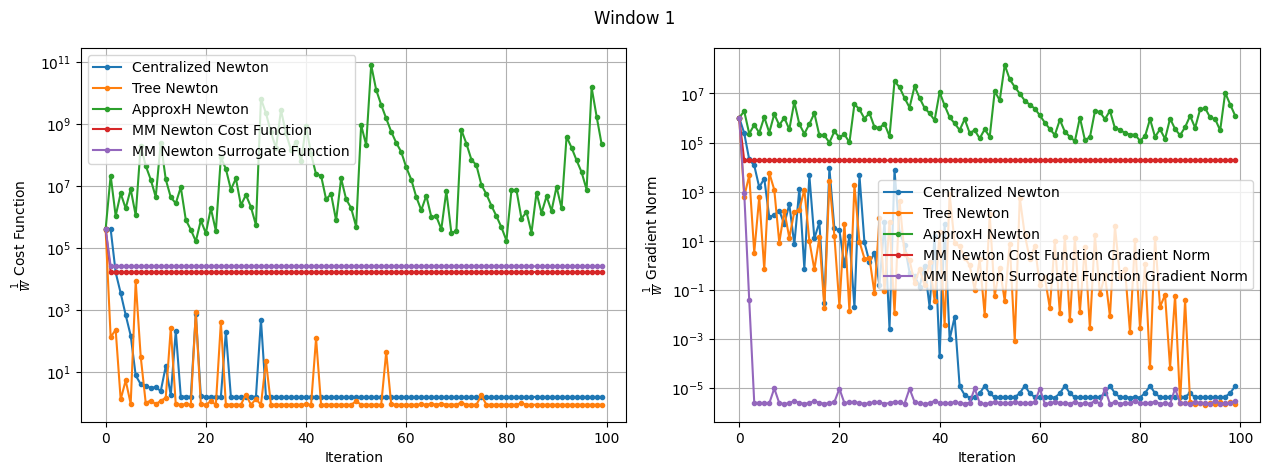


MC runs: 100%|██████████| 1/1 [00:21<00:00, 21.55s/it]


In [57]:
# DISTRIBUTED OVER SEVERAL CPUs
def solve_algorithm(algorithm_name, algorithm, X_est, dt, Y, X_true, n):
    """
    Solves the estimation problem for a given algorithm.
    Returns the algorithm name, updated X_est, and cost function/gradient data for plotting.
    """
    print(f"-------- {algorithm_name} --------")
    
    if algorithm_name == "Centralized Newton":
        X_est = algorithm.solve_for_each_window(dt, X_est, Y[:, :, n : n + W])
        final_errors = [
            np.linalg.norm(X_true[:3, :, n] - X_est[:3]),
            np.linalg.norm(X_true[6:9, :, n] - X_est[6:9]),
            np.linalg.norm(X_true[12:15, :, n] - X_est[12:15]),
            np.linalg.norm(X_true[18:21, :, n] - X_est[18:21])
        ]
        print(f"Final position relative errors: {final_errors} m")
    
    elif algorithm_name in ["Tree Newton", "ApproxH Newton", "MM Newton"]:
        X_est = algorithm.solve_for_each_window(dt, X_est, Y[:, :, n : n + W], X_true[:, :, n])

    # Collect cost function and gradient norm data
    return (
        algorithm_name,
        X_est,
        algorithm.cost_function_values.copy(),
        algorithm.grad_norm_values.copy(),
        algorithm.surrogate_function_values.copy() if hasattr(algorithm, "surrogate_function_values") else [],
        algorithm.surrogate_grad_norm_values.copy() if hasattr(algorithm, "surrogate_grad_norm_values") else []
    )

# ================= MAIN EXECUTION =================
for m in tqdm(range(M), desc="MC runs", leave=True):
    # Generate observations
    Y = np.zeros((9, 1, T))
    for t in range(T):
        Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.multivariate_normal(np.zeros(9), R).reshape((9, 1))

    # Initialize state estimates
    X_est_unkkt = X_initial + initial_dev
    X_est_tree_newton = X_initial + initial_dev
    X_est_approx_newton = X_initial + initial_dev
    X_est_mm = X_initial + initial_dev

    for n in tqdm(range(K - W + 1), desc="Windows", leave=False):
        with ProcessPoolExecutor(max_workers=3) as executor:
            # Run each algorithm in parallel
            future_to_algorithm = {
                executor.submit(solve_algorithm, "Centralized Newton", unkkt, X_est_unkkt, dt, Y, X_true, n): "Centralized Newton",
                executor.submit(solve_algorithm, "Tree Newton", tree_newton, X_est_tree_newton, dt, Y, X_true, n): "Tree Newton",
                executor.submit(solve_algorithm, "ApproxH Newton", approxh_newton, X_est_approx_newton, dt, Y, X_true, n): "ApproxH Newton",
                executor.submit(solve_algorithm, "MM Newton", mm_newton, X_est_mm, dt, Y, X_true, n): "MM Newton"
            }

            # Retrieve results in the main process
            results = {future.result()[0]: future.result()[1:] for future in future_to_algorithm}

        # Extract updated estimates
        X_est_unkkt, cost_unkkt, grad_unkkt, _, _ = results["Centralized Newton"]
        X_est_tree_newton, cost_tree, grad_tree, _, _ = results["Tree Newton"]
        X_est_approx_newton, cost_approx, grad_approx, _, _ = results["ApproxH Newton"]
        X_est_mm, cost_mm, grad_mm, surrogate_cost_mm, surrogate_grad_mm = results["MM Newton"]

        # Plot results **in the main process**
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6.4, 4.8))

        # Cost function values
        ax1.plot(cost_unkkt, '.-', label='Centralized Newton')
        ax1.plot(cost_tree, '.-', label='Tree Newton')
        ax1.plot(cost_approx, '.-', label='ApproxH Newton')
        ax1.plot(cost_mm, '.-', label='MM Newton Cost Function')
        ax1.plot(surrogate_cost_mm, '.-', label='MM Newton Surrogate Function')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel(r'$\frac{1}{W}$ Cost Function')
        ax1.set_yscale('log')
        ax1.grid(True)
        ax1.legend()

        # Gradient norm values
        ax2.plot(grad_unkkt, '.-', label='Centralized Newton')
        ax2.plot(grad_tree, '.-', label='Tree Newton')
        ax2.plot(grad_approx, '.-', label='ApproxH Newton')
        ax2.plot(grad_mm, '.-', label='MM Newton Cost Function Gradient Norm')
        ax2.plot(surrogate_grad_mm, '.-', label='MM Newton Surrogate Function Gradient Norm')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel(r'$\frac{1}{W}$ Gradient Norm')
        ax2.set_yscale('log')
        ax2.grid(True)
        ax2.legend()

        fig.suptitle(f'Window {n + 1}')
        plt.tight_layout()
        plt.show()

        # Update state estimates
        X_est_unkkt = unkkt.dynamic_model.x_new(dt, X_est_unkkt)
        X_est_tree_newton = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton)
        X_est_approx_newton = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton)
        X_est_mm = mm_newton.dynamic_model.x_new(dt, X_est_mm)


In [58]:
if not use_several_cpus:
    # SEQUENTIAL USING ONE CPU
    # Main execution loop
    for m in tqdm(range(M), desc="MC runs", leave=True):
        # Observations
        Y = np.zeros((9, 1, T))
        for t in range(T):
            Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.multivariate_normal(np.zeros(9), R).reshape((9, 1))
    
        # Estimate the state
        X_est_unkkt = X_initial + initial_dev
        X_est_approx_newton = X_initial + initial_dev
        X_est_mm = X_initial + initial_dev
        for n in tqdm(range(K - W + 1), desc="Windows", leave=False):
            print("-------- Centralized Newton --------")
            X_est_unkkt = unkkt.solve_for_each_window(dt, X_est_unkkt, Y[:, :, n : n + W])
            print(f"Final position relative errors: {np.linalg.norm(X_true[:3, :, n] - X_est_unkkt[:3])} m, {np.linalg.norm(X_true[6:9, :, n] - X_est_unkkt[6:9])} m, {np.linalg.norm(X_true[12:15, :, n] - X_est_unkkt[12:15])} m, {np.linalg.norm(X_true[18:21, :, n] - X_est_unkkt[18:21])} m")
            print("-------- ApproxH Newton --------")
            X_est_approx_newton = approxh_newton.solve_for_each_window(dt, X_est_approx_newton, Y[:, :, n : n + W], X_true[:, :, n])
            print("-------- MM Newton --------")
            X_est_mm = mm_newton.solve_for_each_window(dt, X_est_mm, Y[:, :, n : n + W], X_true[:, :, n])
    
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6.4, 4.8))
    
            # First subplot - Cost function values
            ax1.plot(unkkt.cost_function_values, '.-', label='Centralized Newton')
            ax1.plot(approxh_newton.cost_function_values, '.-', label='ApproxH Newton')
            ax1.plot(mm_newton.cost_function_values, '.-', label='MM Newton Cost Function')
            ax1.plot(mm_newton.surrogate_function_values, '.-', label='MM Newton Surrogate Function')
            ax1.set_xlabel('Iteration')
            ax1.set_ylabel('$\frac{1}{W}$ Cost Function')
            ax1.set_yscale('log')
            ax1.grid(True)
            ax1.legend()
    
            # Second subplot - Gradient norm values
            ax2.plot(unkkt.grad_norm_values, '.-', label='Centralized Newton')
            ax2.plot(approxh_newton.grad_norm_values, '.-', label='ApproxH Newton')
            ax2.plot(mm_newton.grad_norm_values, '.-', label='MM Newton Cost Function Gradient Norm')
            ax2.plot(mm_newton.surrogate_grad_norm_values, '.-', label='MM Newton Surrogate Function Gradient Norm')
            ax2.set_xlabel('Iteration')
            ax2.set_ylabel('$\frac{1}{W}$Gradient Norm')
            ax2.set_yscale('log')
            ax2.grid(True)
            ax2.legend()
    
            plt.title(f'Window {n + 1}')
            plt.tight_layout()
            plt.show()
            
            unkkt.cost_function_values = []
            unkkt.grad_norm_values = []
            approxh_newton.cost_function_values = []
            approxh_newton.grad_norm_values = []
            mm_newton.cost_function_values = []
            mm_newton.grad_norm_values = []
            mm_newton.surrogate_function_values = []
            mm_newton.surrogate_grad_norm_values = []
            
            X_est_unkkt = unkkt.dynamic_model.x_new(dt, X_est_unkkt)
            X_est_approx_newton = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton)
            X_est_mm = mm_newton.dynamic_model.x_new(dt, X_est_mm)